In [1]:
import cesium
from cesium import featurize, data_management, features, time_series
import os
import sys
import pandas as pd
import glob
import numpy as np
import tarfile
import joblib
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kendalltau
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

sns.set(style='ticks')
%matplotlib inline

plt.rcParams['figure.figsize'] = (10.0, 8.0)

## Load ASAS science features

In [2]:
asas_science_features, data = featurize.load_featureset('../../survey_classifier_data/data/ASAS_features.npz')
labels = data['labels']
asas_science_features.head()

feature amplitude flux_percentile_ratio_mid20 flux_percentile_ratio_mid35  \
channel         0                           0                           0   
215707     0.6490                    0.128489                    0.266545   
215727     0.5070                    0.118236                    0.221904   
215728     0.7620                    0.102570                    0.194024   
215737     0.6730                    0.193805                    0.344976   
215738     1.0085                    0.066997                    0.125110   

feature flux_percentile_ratio_mid50 flux_percentile_ratio_mid65  \
channel                           0                           0   
215707                     0.430520                    0.650620   
215727                     0.339660                    0.477776   
215728                     0.302758                    0.451540   
215737                     0.510134                    0.615314   
215738                     0.207395                    0.387275   

feature flux_percentile_ratio_mid80   max_slope maximum   median  \
channel                           0           0       0        0   
215707                     0.834348    4.150943  12.052  11.5615   
215727                     0.716511  282.186235  13.384  12.7355   
215728                     0.672194  385.483871  13.679  12.6680   
215737                     0.785504    5.937684  12.165  11.7940   
215738                     0.705230  403.984064  13.763  12.2870   

feature median_absolute_deviation       ...       freq_signif_ratio_31  \
channel                         0       ...                          0   
215707                     0.2240       ...                   0.369249   
215727                     0.0655       ...                   0.627223   
215728                     0.0800       ...                   0.764509   
215737                     0.2130       ...                   0.366569   
215738                     0.0680       ...                   0.422913   

feature freq_varrat freq_y_offset linear_trend medperc90_2p_p  \
channel           0             0            0              0   
215707     0.000040      0.023403    -0.000003       1.093852   
215727     0.000073      0.127756     0.000573       1.088451   
215728     0.000144      0.059574     0.000025       1.089306   
215737     0.000076      0.022272     0.000004       1.233214   
215738     0.000075     -0.002739    -0.000074       1.283705   

feature p2p_scatter_2praw p2p_scatter_over_mad p2p_scatter_pfold_over_mad  \
channel                 0                    0                          0   
215707           0.043788             1.580357                   0.191964   
215727           1.000000             0.946565                   0.946565   
215728           2.368810             0.800000                   1.200000   
215737           0.075429             1.652582                   0.300469   
215738           1.000000             0.720588                   0.808824   

feature p2p_ssqr_diff_over_var scatter_res_raw  
channel                      0               0  
215707                2.149561        0.143760  
215727                0.679154        0.836276  
215728                0.416580        0.710554  
215737                2.228361        0.222649  
215738                0.192218        0.706209  

[5 rows x 70 columns]

## Compute score and plot conf mx for noisified ASAS model

In [3]:
# Load ASAS science models and do predictions
# Using 5, 10, 15 and 20
nlcs = []
scores = []
for x in ['1', '2', '3', '4', '5', '10', '15', '20', '30', '50', '75', '100']:
    model = joblib.load('data_no_dups_many_asas_new/noisified_ASAS_model_compressed_{}.pkl'.format(x))
    preds = model.predict(asas_science_features)
    score = np.mean(preds == labels)
    nlcs.append(int(x))
    scores.append(score)
    print(x, '-', score)
    
scores_df = pd.DataFrame({'num_lcs_used': nlcs, 'score': scores})

1 - 0.66049382716
2 - 0.681481481481
3 - 0.691358024691
4 - 0.702469135802
5 - 0.703703703704
10 - 0.718518518519
15 - 0.740740740741
20 - 0.743209876543
30 - 0.754320987654
50 - 0.762962962963
75 - 0.765432098765
100 - 0.77037037037


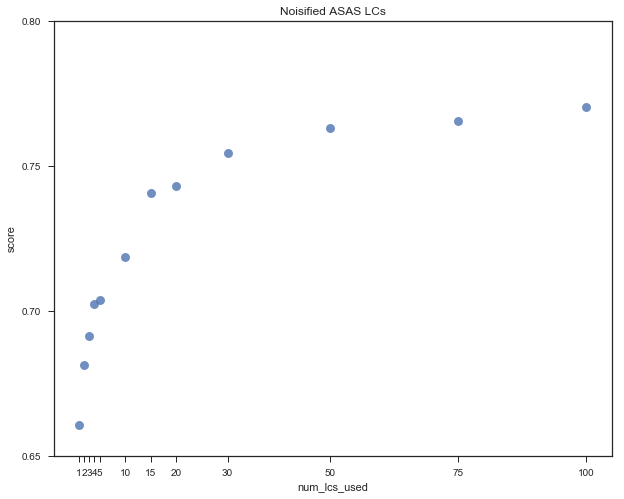

In [8]:
plot = sns.regplot(x='num_lcs_used', y='score', data=scores_df, scatter_kws={"s": 80}, fit_reg=False)
plot.set_yticks([0.65, 0.7, 0.75, 0.8])
plot.set_xticks([1, 2, 3, 4, 5, 10, 15, 20, 30, 50, 75, 100])
plot.set_title('Noisified ASAS LCs')

In [9]:
plot.get_figure().savefig('plots/N_lcs_versus_score_ASAS_100.pdf')

In [10]:
# Sort labels for confusion mx
conf_labels = sorted(list(set(list(labels) + list(preds))))
print(conf_labels)

['Beta_Cephei', 'Beta_Lyrae', 'Beta_Persei', 'ChemPeculiar', 'ClassT_Tauri', 'Classical_Cepheid', 'Delta_Scuti', 'Ellipsoidal', 'Herbig_AEBE', 'LSP', 'Mira', 'MultiMode_Cepheid', 'PopII_Cepheid', 'Pulsating_Be', 'RCB', 'RR_Lyrae_DM', 'RR_Lyrae_FM', 'RR_Lyrae_FO', 'RSG', 'RS_CVn', 'RV_Tauri', 'SARG_A', 'SARG_B', 'SX_Phe', 'S_Doradus', 'Semireg_PV', 'W_Ursae_Maj', 'Weakline_T_Tauri']


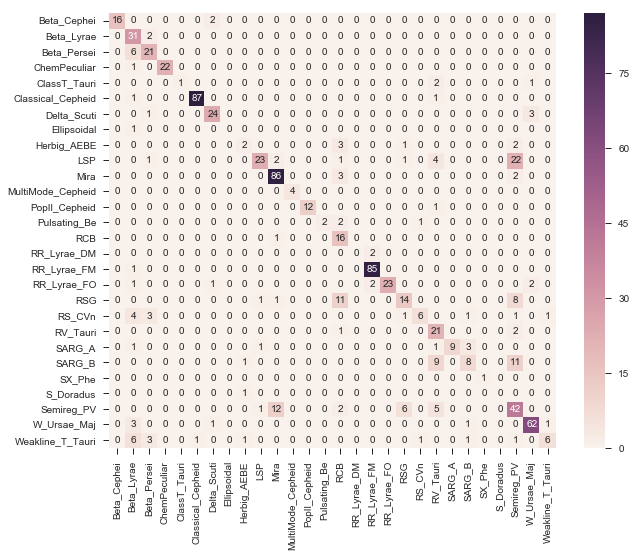

In [15]:
# Plot confusion matrix
conf = confusion_matrix(labels, preds, labels=conf_labels)

cm_df = pd.DataFrame(conf, index=conf_labels, columns=conf_labels)

plot = sns.heatmap(cm_df, annot=True)
plot.get_figure().savefig('plots/ASAS_conf_mx_100.pdf')

## Train/test split on original ASAS sci feats to compute scores

In [12]:
# Drop all classes with fewer than 2 instances
MIN_EXAMPLES = 2
classes_to_drop = [label for label in labels if list(labels).count(label) < MIN_EXAMPLES]
inds_to_drop = [i for i, l in enumerate(labels) if l in classes_to_drop]
asas_fs = asas_science_features.drop(asas_science_features.index.values[inds_to_drop])
asas_fs_labels = np.array([l for i, l in enumerate(labels) if l not in classes_to_drop])

# # Train/test split
train, test = train_test_split(np.arange(len(asas_fs_labels)), train_size=0.8, test_size=0.2,
                               stratify=asas_fs_labels, random_state=6)

# Build ASAS model
asas_model = RandomForestClassifier(n_estimators=1000)
asas_model.fit(asas_fs.iloc[train], asas_fs_labels[train])

# Predict
pred = asas_model.predict(asas_fs)
print('*' * 20, 'ASAS train score:', np.mean(pred[train] == asas_fs_labels[train]))
print('*' * 20, 'ASAS test score:', np.mean(pred[test] == asas_fs_labels[test]))

******************** ASAS train score: 1.0
******************** ASAS test score: 0.808641975309


## Compute TRAIN score and plot conf mx for original ASAS model

In [13]:
# Load ASAS science model and do predictions
model = joblib.load('data_no_dups/ASAS_model_compressed.pkl')
preds = model.predict(asas_science_features)
score = np.mean(preds == labels)
print(score)

FileNotFoundError: [Errno 2] No such file or directory: 'data_no_dups/ASAS_model_compressed.pkl'

['Beta_Cephei', 'Beta_Lyrae', 'Beta_Persei', 'ChemPeculiar', 'ClassT_Tauri', 'Classical_Cepheid', 'Delta_Scuti', 'Ellipsoidal', 'Herbig_AEBE', 'LSP', 'Mira', 'MultiMode_Cepheid', 'PopII_Cepheid', 'Pulsating_Be', 'RCB', 'RR_Lyrae_DM', 'RR_Lyrae_FM', 'RR_Lyrae_FO', 'RSG', 'RS_CVn', 'RV_Tauri', 'SARG_A', 'SARG_B', 'SX_Phe', 'S_Doradus', 'Semireg_PV', 'W_Ursae_Maj', 'Weakline_T_Tauri']


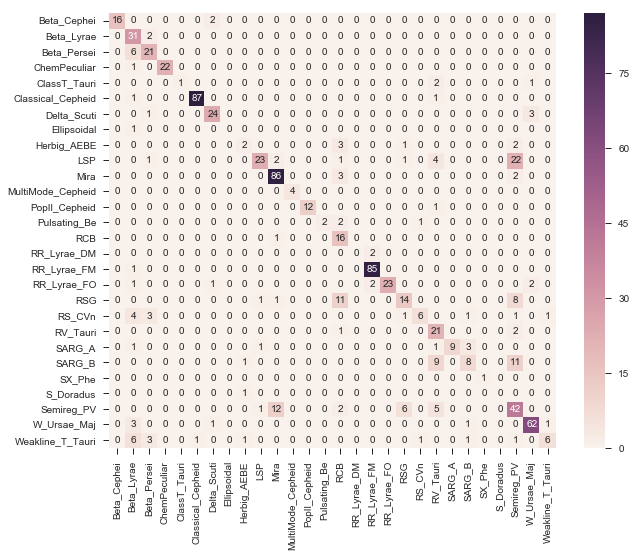

In [14]:
# Sort labels for confusion mx
conf_labels = sorted(list(set(list(labels) + list(preds))))
print(conf_labels)

# Plot confusion matrix
conf = confusion_matrix(labels, preds, labels=conf_labels)

cm_df = pd.DataFrame(conf, index=conf_labels, columns=conf_labels)

sns.heatmap(cm_df, annot=True)